UEP run 15 results. Using $\mu = 10^4$. This run is notable in that is uses a different $(A, b)$ combination in the optimization such that the January scaling factors are held to $1$.

For starting positions, we made the following choices
1. $w$: use the negative stop of LEP 08
2. $c$: for those indices corresponding to the equality constraints, we set those to 0. Otherwise, looking at the stopping position of UEP 15, we see that these elements are at most around 0.05, so those positions are set to 0.01.
3. $\lambda$: we start at a vector of 1s. This notebook both analyzes the results and generates the starting positions.
1. Optimization sub-results
2. Generate starting positions

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import pickle
from scipy import stats

In [2]:
from generate_opt_objects import A_b_generation

**PNC:/Users/mikestanley/anaconda3/envs/mc_sampling/lib/python3.8/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  pyproj could not be found, so IO/API coordinates cannot be converted to lat/lon; to fix, install pyproj or basemap (e.g., `pip install pyproj)`


In [3]:
# results base directory
BASE_DIR = './data/carbon_flux/results'

# save filepath
SAVE_FIG_BASE = '../figures/interval_optimizations/continental_US_jun2010/dual/16'

In [4]:
# paths
OBS_FP = '../fixed_optimization_inputs/y_affine_corrected.npy'

In [5]:
# get necessary objects
with open(OBS_FP, 'rb') as f:
    y_obs = np.load(f)
    
# gosat data
with open('../fixed_optimization_inputs/gosat_df_jan1_aug31_2010.csv', 'rb') as f:
    gosat_df = pd.read_csv(f)
L_inv_vec = 1 / gosat_df.xco2_unc.values
    
# tranform the data
y_tilde = np.multiply(L_inv_vec, y_obs)

CONSTR_DIR = '/Users/mikestanley/Research/Carbon_Flux/optimization/data/sign_corrected'
A, b = A_b_generation(
    box_constraint_fp=CONSTR_DIR + '/scipy_bnds.pkl',
    unity_indices=np.arange(46 * 72)
)

FUNC_FP = '/Users/mikestanley/Research/Carbon_Flux/optimization'
FUNC_FP += '/src_admm/data/carbon_flux/objects/na_june_functional.npy'
with open(FUNC_FP, 'rb') as f:
    h = np.load(f)

In [6]:
# psi_alpha
with open('./data/carbon_flux/objects/opt_res_cont.pkl', 'rb') as f:
    opt_slack = pickle.load(f)
    
PSI_ALPHA = np.sqrt(stats.chi2.ppf(q=.95, df=1) + opt_slack[1])

# Plotting functions

In [7]:
def global_avg_plot(w_ser, title_str=None, figsize=(8, 5)):
    """
    Globally averaged weights at daily, weekly, and month res
    
    Parameters
    ----------
        w_ser (pandas series) : weights indexed by time
    """
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    ts_day = w_ser.resample('D').mean()
    ts_week = w_ser.resample('W').mean()
    ts_month = w_ser.resample('M').mean()
    ts_day.plot(ax=ax, label='Day')
    ts_week.plot(ax=ax, label='Week')
    ts_month.plot(ax=ax, label='Month')
    ax.axhline(0, linestyle='--', color='gray')
    ax.legend()
    ax.set_title(title_str)
    plt.show()
    
def month_map_plot(df, w_col_str, norm, vmin=None, vmax=None, figsize=(12, 16), save_fp=None):
    """
    Monthly heat maps for the given weights
    
    Parameters
    ----------
        df        (pandas dataframe)  : contains columns - 'month', 'lon', 'lat', and w_col_str
        w_col_str (str)               : name of w column in df to use
        norm      (mcolors.Normalize) : for color scheme
    """
    # w start
    fig, ax = plt.subplots(ncols=2, nrows=4, figsize=figsize)
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

    for i in range(8):
        row_idx = i // 2
        col_idx = i % 2
        month_idxs = df['month'].astype(int) == i + 1
        sp_i = ax[row_idx, col_idx].scatter(
            df['lon'][month_idxs], df['lat'][month_idxs],
            c=df[w_col_str][month_idxs],
            norm=norm, vmin=vmin, vmax=vmax,
            s=14, cmap='seismic'
        )
        ax[row_idx, col_idx].set_title(months[i])

    plt.colorbar(sp_i,ax=ax[0, 0])
    if save_fp:
        plt.savefig(save_fp, dpi=300)
        plt.close()
    else:
        plt.show()

# Optimization Diagnostics

# Starting positions

#### Look at previous

In [27]:
# read in the ending points from LEP08
with open(BASE_DIR + '/08/final_results.pkl', 'rb') as f:
    final_res_08 = pickle.load(f)
    
# get w
w_lep08 = final_res_08['w_opt_output']['vectors'][-1].copy()

In [13]:
# previous c
with open(BASE_DIR + '/15/opt_output_05.pkl', 'rb') as f:
    final_res_15 = pickle.load(f)

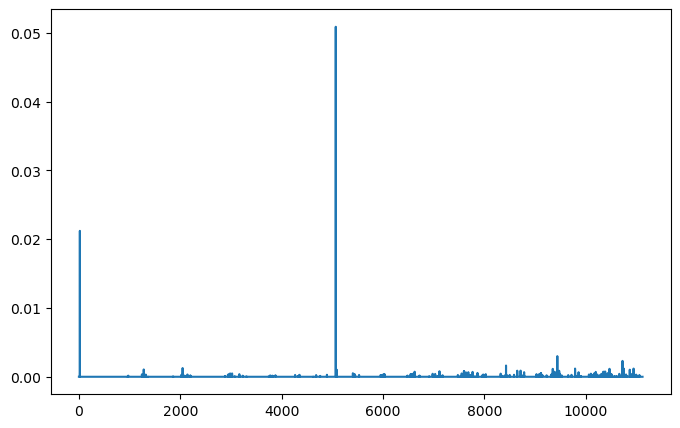

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(final_res_15['c_opt_vecs'][5])
plt.show()

In [24]:
# create the c starting vector

# identify the indices where the constraint is definitely active
active_start_idx = np.where(np.abs(b) == 1)[0][0]
c_start = np.zeros(b.shape[0])
c_start[:active_start_idx] = 0.01

In [29]:
# save the new points
SAVE_BASE_SP = './data/carbon_flux/results/16/intermediate_starts'
with open(SAVE_BASE_SP + '/w_start_fromLEP.npy', 'wb') as f:
    np.save(file=f, arr=-w_lep08)  # note the negative
    
# saving c starting position
with open(SAVE_BASE_SP + '/c_start_active0.npy', 'wb') as f:
    np.save(file=f, arr=c_start)
    
# saving lambda starting position
with open(SAVE_BASE_SP + '/lambda_start_unity.npy', 'wb') as f:
    np.save(file=f, arr=np.ones(final_res_15['lambda_opt_vecs'].shape[1]))